# Illustration of JAX-cosmo on a DES Y1-like analysis

In [1]:
%pylab inline
import os.path
import jax
import jax.numpy as np
import jax_cosmo as jc

Populating the interactive namespace from numpy and matplotlib


## Retrieving  the nz data

In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)

Text(0.5, 1.0, 'Source redshift distributions')

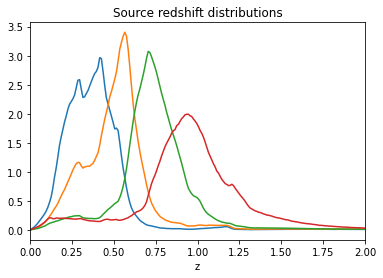

In [3]:
# Let's plot the NZs
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')


In [4]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(0.0, 2.0)

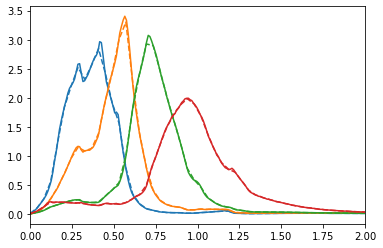

In [5]:
z = linspace(0,2)
for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)


##  Let's build  a model for C_ell

In [6]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [1.0, 2.0, 3.0, 4.0],
 [5.0, 6.0, 7.0, 8.0],
 [DeviceArray(1., dtype=float32), DeviceArray(2., dtype=float32)])

In [7]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [8]:
## Let's get the covariance
f_sky = 1321./41253.
print("f_sky", f_sky)
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky)
    
    return cov

f_sky 0.03202191355780186


In [9]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [10]:
# Let's try it out
from functools import partial

FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.)

fid_cosmo = FiducialCosmo()
fid_params = get_params_vec(fid_cosmo, 
                            [1.2e-2, 1.2e-2, 1.2e-2, 1.2e-2],
                            [0.1e-2, -1.9e-2, 0.9e-2, -1.8e-2],
                            [0.5, 0.])

In [11]:
cl_wl = mu(fid_params)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [12]:
%timeit mu(fid_params).block_until_ready()

377 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


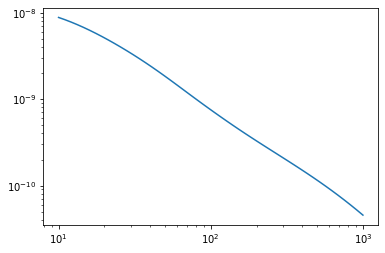

In [13]:
loglog(ell, cl_wl[0])

In [14]:
C = cov(fid_params)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

In [15]:
j = jacobian(fid_params)

In [16]:
#%timeit jacobian(fid_params).block_until_ready()

In [17]:
# And we get the fisher matrix from the jacobian and covariance
F = np.einsum('ia,ij,jb',j,np.linalg.inv(C),j)

# Add priors to systematics
import numpy as onp
d = onp.zeros(16)
d[6] = 1./(2.3e-2)**2
d[7] = 1./(2.3e-2)**2
d[8] = 1./(2.3e-2)**2
d[9] = 1./(2.3e-2)**2
d[10] = 1./(1.6e-2)**2
d[11] = 1./(1.3e-2)**2
d[12] = 1./(1.1e-2)**2
d[13] = 1./(2.2e-2)**2

F = F + np.diag(d)

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, inds=[1,0], nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  i,j = inds
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  block_cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(block_cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos[[i,j]], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(i)
  s2 = 1.5*nstd*sigma_marg(j)
  ax.set_xlim(pos[i] - s1, pos[i] + s1)
  ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

Text(27.0, 0.5, 'sigma8')

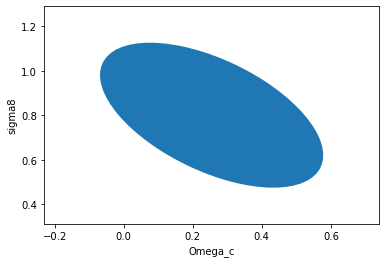

In [19]:
plot_contours(F, fid_params)
xlabel('Omega_c')
ylabel('sigma8')

## Fisher matrices are ok, but let's try proper inference

In [20]:
import numpyro
import numpyro.distributions as dist

In [22]:
@jax.jit
def model_fn(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)
    return cl.flatten()

In [28]:
# Let's define our model using numpyro
def model():
    #  Cosmological params
    Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
    sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
    Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
    h = numpyro.sample('h', dist.Uniform(0.55, 0.9))
    n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.97))
    w0 = numpyro.sample('w0', dist.Uniform(-2.0, -0.33))
    
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    
    # Astrophysical params
    A = numpyro.sample('A', dist.Uniform(-5., 5.))
    eta = numpyro.sample('eta', dist.Uniform(-5., 5.))
    
    # Now that params are defined, here is the forward model
    cosmo = FiducialCosmo(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, w0=w0)
    
    signal = model_fn(get_params_vec(cosmo, m, [dz1, dz2, dz3, dz4], [A, eta]))
    
    # And here we define the likelihood
    numpyro.sample('cl_wl', dist.MultivariateNormal(signal, C))

In [29]:
from numpyro.handlers import seed, trace
rng_key = jax.random.PRNGKey(0)

In [30]:
tr = numpyro.handlers.trace(seed(model, rng_key))

In [31]:
res = tr.get_trace()

In [32]:
data = res['cl_wl']['value']

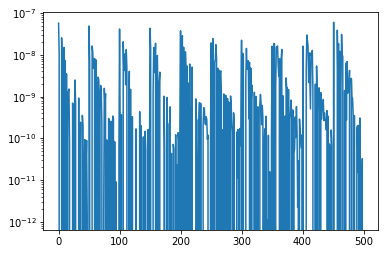

In [33]:
semilogy(data)

In [34]:
cond_model = numpyro.handlers.condition(model, {'cl_wl':data})

In [35]:
nuts_kernel = numpyro.infer.NUTS(cond_model)

In [36]:
rng_key = jax.random.PRNGKey(0)

In [37]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=500, 
                          num_samples=1000,
                          jit_model_args=True)

In [ ]:
mcmc.run(rng_key, extra_fields=('potential_energy',))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num